In [1]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings.configs
import importlib
from data_formatters import utils
import torch.optim as optim
import torch
from tqdm import tqdm
import pickle
import time

In [2]:
pd.set_option('max_columns', 1000)

In [3]:
importlib.reload(utils)

<module 'data_formatters.utils' from '/home/arda/Desktop/thesis/submodules/Temporal_Fusion_Transform/data_formatters/utils.py'>

In [4]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('m4', 'outputs')

with open('data_formatter_m4.pkl', 'rb') as input:
    data_formatter = pickle.load(input)

# data_formatter = config.make_data_formatter()
# 
# 
# print("*** Training from defined parameters for {} ***".format('m4'))
# data_csv_path = 'data/m4.csv'
# print("Loading & splitting data...")
# raw_data = pd.read_csv(data_csv_path, index_col=0)
# print(raw_data.shape)
# start = time.time()
# train, valid, test = data_formatter.split_data(raw_data)
# train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
# )
# print(time.time()-start)

# with open('train_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(train, output, pickle.HIGHEST_PROTOCOL)

with open('train_m4.pkl', 'rb') as input:
    train = pickle.load(input)

# with open('valid_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(valid, output, pickle.HIGHEST_PROTOCOL)

# with open('test_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(test, output, pickle.HIGHEST_PROTOCOL)

In [5]:
# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

fixed_params.update(params)
fixed_params['batch_first'] = True
fixed_params['name'] = 'test'
fixed_params['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fixed_params['minibatch_size'] = 256
fixed_params['category_count'] = [6]
device = fixed_params['device']

# with open('data_formatter_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(data_formatter, output, pickle.HIGHEST_PROTOCOL)


In [6]:
max_samples = 256 * 1000 * 2
# elect = ts_dataset.TSDataset(fixed_params, max_samples, train)

# with open('ts_dataset_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(elect, output, pickle.HIGHEST_PROTOCOL)

with open('ts_dataset_m4.pkl', 'rb') as input:
    elect = pickle.load(input)

In [7]:
loader = DataLoader(
            elect,
            batch_size=fixed_params['minibatch_size'],
            num_workers=2,
            shuffle=False
        )

In [8]:
importlib.reload(tft_model)
model = tft_model.TFT(fixed_params).to(device)

{'total_time_steps': 54, 'num_encoder_steps': 36, 'num_epochs': 100, 'early_stopping_patience': 5, 'multiprocessing_workers': 5, 'column_definition': [('id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('time', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('value', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('time_cat', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('category', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)], 'input_size': 3, 'output_size': 1, 'category_counts': [6], 'input_obs_loc': [0], 'static_input_loc': [2], 'known_regular_inputs': [1], 'known_categorical_inputs': [0], 'dropout_rate': 0.1, 'hidden_layer_size': 160, 'learning_rate': 0.001, 'minibatch_size': 256, 'max_gradient_norm': 0.01, 'num_heads': 4, 'stack_size': 1, 'batch_first': True, 'name': 'test', 'device': device(type='cuda'), 'category_count': [6]}
num_categorical_variables
1


In [9]:
q_loss_func = tft_model.QuantileLoss([0.5])
# import sys
# sys.path.append('/home/arda/Desktop/thesis/')
# from loss_modules import PinballLoss
# q_loss_func = PinballLoss(0.45, device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
model.train()
epochs=150
losses = []
for i in range(epochs):
    epoch_loss = [] 
    progress_bar = tqdm(enumerate(loader), total=len(loader))
    for batch_num, batch in progress_bar:
        optimizer.zero_grad()
        output, all_inputs, attention_components = model(batch['inputs'])
        loss= q_loss_func(output[:,:,:].view(-1,1), batch['outputs'][:,:,0].flatten().float().to(device))
#         loss= q_loss_func(output[:,:,:].squeeze(2), batch['outputs'][:,:,0].float().to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), fixed_params['max_gradient_norm'])
        optimizer.step()
        epoch_loss.append(loss.item())
    
    losses.append(np.mean(epoch_loss))
    if loss.item() <= min(losses):
        torch.save(model.state_dict(), 'm4_best_model_smape_loss.pth')
        
    print(np.mean(epoch_loss))
    

100%|██████████| 2000/2000 [03:29<00:00,  9.57it/s]

0.18452748523652554



100%|██████████| 2000/2000 [03:35<00:00,  9.26it/s]

0.17292365770041943



100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]

0.166542564637959



100%|██████████| 2000/2000 [03:27<00:00,  9.63it/s]

0.16154571641981602



100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]

0.15965299769490957



100%|██████████| 2000/2000 [03:29<00:00,  9.53it/s]

0.15843212035298349



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.15737915706634523



100%|██████████| 2000/2000 [03:27<00:00,  9.63it/s]

0.15641349931806325



100%|██████████| 2000/2000 [03:28<00:00,  9.61it/s]

0.15534071508049965



100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]

0.1539907605499029



100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]


0.15182832358777523


100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]

0.15018359600752593



100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]


0.14925745560973883


100%|██████████| 2000/2000 [03:25<00:00,  9.71it/s]

0.14852910717576742



100%|██████████| 2000/2000 [03:26<00:00,  9.69it/s]

0.1479884796924889



100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]

0.14748809743300081



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.1470029911287129



100%|██████████| 2000/2000 [03:31<00:00,  9.45it/s]

0.14656908706203103



100%|██████████| 2000/2000 [03:29<00:00,  9.53it/s]


0.1462764961719513


100%|██████████| 2000/2000 [03:29<00:00,  9.54it/s]

0.14592055943608284



100%|██████████| 2000/2000 [03:31<00:00,  9.46it/s]

0.14558025342226028



100%|██████████| 2000/2000 [03:24<00:00,  9.76it/s]

0.14530243143439292



100%|██████████| 2000/2000 [03:25<00:00,  9.75it/s]

0.1450581739395857



100%|██████████| 2000/2000 [03:28<00:00,  9.60it/s]

0.14476734834909438



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.14454747395589948



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.1442875625118613



100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.14404481476172804



100%|██████████| 2000/2000 [03:25<00:00,  9.72it/s]

0.1438149829991162



100%|██████████| 2000/2000 [03:25<00:00,  9.72it/s]

0.14358205102011562



100%|██████████| 2000/2000 [03:27<00:00,  9.63it/s]

0.14338577184826135



100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]

0.14317622193321586



100%|██████████| 2000/2000 [03:25<00:00,  9.71it/s]

0.14299399625882506



100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.14279768804460763



100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]


0.1425467251241207


100%|██████████| 2000/2000 [03:27<00:00,  9.66it/s]

0.14241262998431922



100%|██████████| 2000/2000 [03:24<00:00,  9.76it/s]

0.14216059075668455



100%|██████████| 2000/2000 [03:28<00:00,  9.61it/s]

0.14200059029459952



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.14182017417997123



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.14163953144848346



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.14143096588924528



100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.14122673442214728



100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]

0.14103529678285123



100%|██████████| 2000/2000 [03:26<00:00,  9.66it/s]

0.1408644120618701



100%|██████████| 2000/2000 [03:28<00:00,  9.61it/s]

0.14069369266927242



100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]


0.1404792498983443


100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]

0.14031359156221151



100%|██████████| 2000/2000 [03:27<00:00,  9.63it/s]

0.1402641029432416



100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]

0.14026712398231028



100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.1397745491117239



100%|██████████| 2000/2000 [03:26<00:00,  9.70it/s]

0.1395764686614275



100%|██████████| 2000/2000 [03:28<00:00,  9.60it/s]

0.13940190412476658



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.13922963105142117



100%|██████████| 2000/2000 [03:28<00:00,  9.61it/s]

0.13903800493478774



100%|██████████| 2000/2000 [03:28<00:00,  9.61it/s]

0.13887011405080557



100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.13867379231750965



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.13847548646107316



100%|██████████| 2000/2000 [03:27<00:00,  9.66it/s]

0.1383062472566962



100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]

0.13810359989851714



100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]

0.1379533359631896



100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]

0.13775286836922168



100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]

0.13757221169769765



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.13739473562687635



100%|██████████| 2000/2000 [03:26<00:00,  9.66it/s]

0.13725185638666154



100%|██████████| 2000/2000 [03:26<00:00,  9.70it/s]

0.13706201573461294



100%|██████████| 2000/2000 [03:28<00:00,  9.60it/s]

0.13686862793564797



100%|██████████| 2000/2000 [03:29<00:00,  9.56it/s]

0.13669820211827755



100%|██████████| 2000/2000 [03:26<00:00,  9.70it/s]


0.13653795079886913


100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.1363383644334972



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.13613307336717845



100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.1359990914128721



100%|██████████| 2000/2000 [03:26<00:00,  9.69it/s]

0.13580753331258894



100%|██████████| 2000/2000 [03:26<00:00,  9.69it/s]

0.13562440897524358



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.13545774897560478



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.13527038531005384



100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]

0.13511257534846663



100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.13491834322735669



100%|██████████| 2000/2000 [03:26<00:00,  9.70it/s]

0.13475847977772354



100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.13457102067396046



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.13437538900598883



100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s]

0.13424533512070774



100%|██████████| 2000/2000 [03:26<00:00,  9.69it/s]

0.13407606170326472



100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]

0.13388878809288143



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.1336915201842785



100%|██████████| 2000/2000 [03:36<00:00,  9.22it/s]

0.13354397810995577



100%|██████████| 2000/2000 [03:35<00:00,  9.28it/s]


0.1333617355376482


100%|██████████| 2000/2000 [03:28<00:00,  9.60it/s]

0.13322706668823958



100%|██████████| 2000/2000 [03:27<00:00,  9.63it/s]

0.1330215318277478



100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]

0.13283707962930202



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.13268263209983708



100%|██████████| 2000/2000 [03:29<00:00,  9.56it/s]

0.13254003208875656



100%|██████████| 2000/2000 [03:30<00:00,  9.49it/s]

0.13231110383197664



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.13216697783768178



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.13202361949160696



100%|██████████| 2000/2000 [03:28<00:00,  9.60it/s]

0.13187271125614644



100%|██████████| 2000/2000 [03:28<00:00,  9.60it/s]

0.13169570961222052



100%|██████████| 2000/2000 [03:28<00:00,  9.60it/s]

0.13155117144435644



100%|██████████| 2000/2000 [03:26<00:00,  9.69it/s]

0.13139809706807137



100%|██████████| 2000/2000 [03:28<00:00,  9.60it/s]

0.13122196067124606



100%|██████████| 2000/2000 [03:30<00:00,  9.51it/s]

0.13109042996540665



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.13091528656706214



100%|██████████| 2000/2000 [03:27<00:00,  9.63it/s]

0.13079258658736945



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.1305797547996044



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.13044257236644627



100%|██████████| 2000/2000 [03:29<00:00,  9.54it/s]

0.13031320620700718



100%|██████████| 2000/2000 [03:30<00:00,  9.52it/s]

0.13010537550970913



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.12996780743449926



100%|██████████| 2000/2000 [03:29<00:00,  9.54it/s]

0.12982061200216413



100%|██████████| 2000/2000 [03:28<00:00,  9.60it/s]

0.12968048687279224



100%|██████████| 2000/2000 [03:29<00:00,  9.55it/s]

0.12950152602419257



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.12937510553747417



100%|██████████| 2000/2000 [03:28<00:00,  9.61it/s]

0.12922987119480966



100%|██████████| 2000/2000 [03:27<00:00,  9.63it/s]

0.12909889681637288



100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]

0.12895954329147935



100%|██████████| 2000/2000 [03:29<00:00,  9.55it/s]

0.12880520814657212



100%|██████████| 2000/2000 [03:31<00:00,  9.47it/s]

0.12867890079319477



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.12852838717028497



100%|██████████| 2000/2000 [03:26<00:00,  9.68it/s]

0.1283844059742987



100%|██████████| 2000/2000 [03:27<00:00,  9.64it/s]

0.1282639614455402



100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]

0.1281365467980504



100%|██████████| 2000/2000 [03:29<00:00,  9.53it/s]

0.1279835916981101



100%|██████████| 2000/2000 [03:27<00:00,  9.63it/s]

0.12787326313182712



100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]

0.12769507445767522



100%|██████████| 2000/2000 [03:29<00:00,  9.54it/s]

0.12756695568934082



100%|██████████| 2000/2000 [03:26<00:00,  9.69it/s]

0.127426438100636



100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]

0.12724116598069668



100%|██████████| 2000/2000 [03:28<00:00,  9.57it/s]

0.12710724361613393



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]


0.12700493296608328


100%|██████████| 2000/2000 [03:26<00:00,  9.68it/s]

0.12690366138890385



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.12674562999233605



100%|██████████| 2000/2000 [03:27<00:00,  9.65it/s]

0.1266388614550233



100%|██████████| 2000/2000 [03:29<00:00,  9.56it/s]

0.12651887243613602



100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]

0.12635682188346983



100%|██████████| 2000/2000 [03:29<00:00,  9.54it/s]

0.1262594072110951



100%|██████████| 2000/2000 [03:30<00:00,  9.51it/s]

0.12616435431689024



100%|██████████| 2000/2000 [03:26<00:00,  9.69it/s]

0.12597431195527314



100%|██████████| 2000/2000 [03:29<00:00,  9.54it/s]

0.12579179809615015



100%|██████████| 2000/2000 [03:28<00:00,  9.61it/s]

0.1257921583391726



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]


0.1256288397014141


100%|██████████| 2000/2000 [03:28<00:00,  9.58it/s]

0.1254954149276018



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.125350655246526



100%|██████████| 2000/2000 [03:29<00:00,  9.55it/s]

0.1252597320601344



100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]

0.12511405480280519



100%|██████████| 2000/2000 [03:30<00:00,  9.50it/s]

0.12498325885832309



100%|██████████| 2000/2000 [03:29<00:00,  9.55it/s]

0.12489839425683022



100%|██████████| 2000/2000 [03:28<00:00,  9.59it/s]

0.12479459115117789



100%|██████████| 2000/2000 [03:34<00:00,  9.31it/s]

0.12463189613446593



100%|██████████| 2000/2000 [03:33<00:00,  9.37it/s]

0.12455935816839338



100%|██████████| 2000/2000 [03:31<00:00,  9.46it/s]

0.12442478743940592



100%|██████████| 2000/2000 [03:34<00:00,  9.33it/s]

0.12434013846889139



100%|██████████| 2000/2000 [03:32<00:00,  9.43it/s]

0.12421388157829642


43


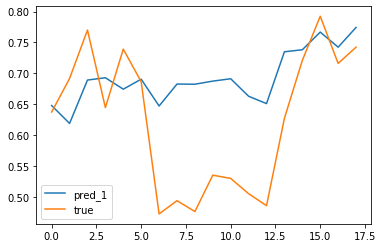

In [12]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(64)
print(ind)
plt.plot(output[ind,:,0].detach().cpu().numpy(), label='pred_1')
# plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
# plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()